# Data exploration

---

This notebook serves as an initial data set exploration sandbox. In particular, we are interested in which ORF experiments are available for each source and what is their intersection with the genes available in a given gene-gene interactome.

---

## 0. Environmental setup

In [171]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from venn import venn
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import requests
from io import BytesIO
from matplotlib import image as mpimg
import boto3
import os
from botocore import UNSIGNED
from botocore.client import Config
from tifffile import imsave, imread
from urllib.error import HTTPError
from scipy.stats import pearsonr

import warnings

warnings.filterwarnings("ignore")

seed = 1234

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Read in data



In [130]:
gene_ia_embs = pd.read_csv("other_data/all_gene_embeddings_clusters.csv", index_col=0)
gene_ia_set = set(gene_ia_embs.gene)
specific_targets = set(
    pd.read_csv(
        "/home/paysan_d/PycharmProjects/image2reg/data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_0/train_cmatrix.csv",
        index_col=0,
    ).index
) - set(["EMPTY"])

<IPython.core.display.Javascript object>

In [137]:
rohban_md = pd.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/images/metadata/metadata_images.csv",
    index_col=0,
)

<IPython.core.display.Javascript object>

In [3]:
well_data = pd.read_csv("metadata/well.csv")
orf_data = pd.read_csv("metadata/orf.csv")
plate_data = pd.read_csv("metadata/plate.csv")

<IPython.core.display.Javascript object>

---

## 2. Exploratory data analysis

After having read in the data, we will now explore the data. To this end, we will first look at the overlap of experiments targetting genes for overexpression that are part of the gene gene interactome we had derived in the Image2Reg project.

### 2.1. Interactome coverage

In [4]:
all_orf_data = well_data.merge(
    orf_data, right_on="Metadata_JCP2022", left_on="Metadata_JCP2022", how="inner"
)
all_orf_data = all_orf_data.merge(
    plate_data.loc[:, ["Metadata_Plate", "Metadata_Batch", "Metadata_PlateType"]],
    right_on="Metadata_Plate",
    left_on="Metadata_Plate",
)
all_orf_data.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Batch,Metadata_PlateType
0,source_4,BR00117035,A01,JCP2022_905588,ccsbBroad304_05979,ORF000779.1_TRC304.1,pLX_304,NM_001261.4,CDK9,1025,9606,cyclin dependent kinase 9,100.0,1116.0,trt,2021_04_26_Batch1,ORF
1,source_4,BR00117035,A02,JCP2022_912241,ccsbBroad304_13129,ORF007469.1_TRC304.1,pLX_304,NM_001352984.2,HMGB4,127540,9606,high mobility group box 4,99.1,336.0,trt,2021_04_26_Batch1,ORF
2,source_4,BR00117035,A03,JCP2022_900266,ccsbBroad304_00289,ORF011627.1_TRC304.1,pLX_304,NM_001805.3,CEBPE,1053,9606,CCAAT enhancer binding protein epsilon,100.0,843.0,trt,2021_04_26_Batch1,ORF
3,source_4,BR00117035,A04,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon,2021_04_26_Batch1,ORF
4,source_4,BR00117035,J21,JCP2022_915129,ccsbBroad304_99988,ORFC00002.1_TRC304.1,pLX_304,HcRed.1,HcRed,HcRed,CONTROL,NaN,NaN,824.0,negcon,2021_04_26_Batch1,ORF


<IPython.core.display.Javascript object>

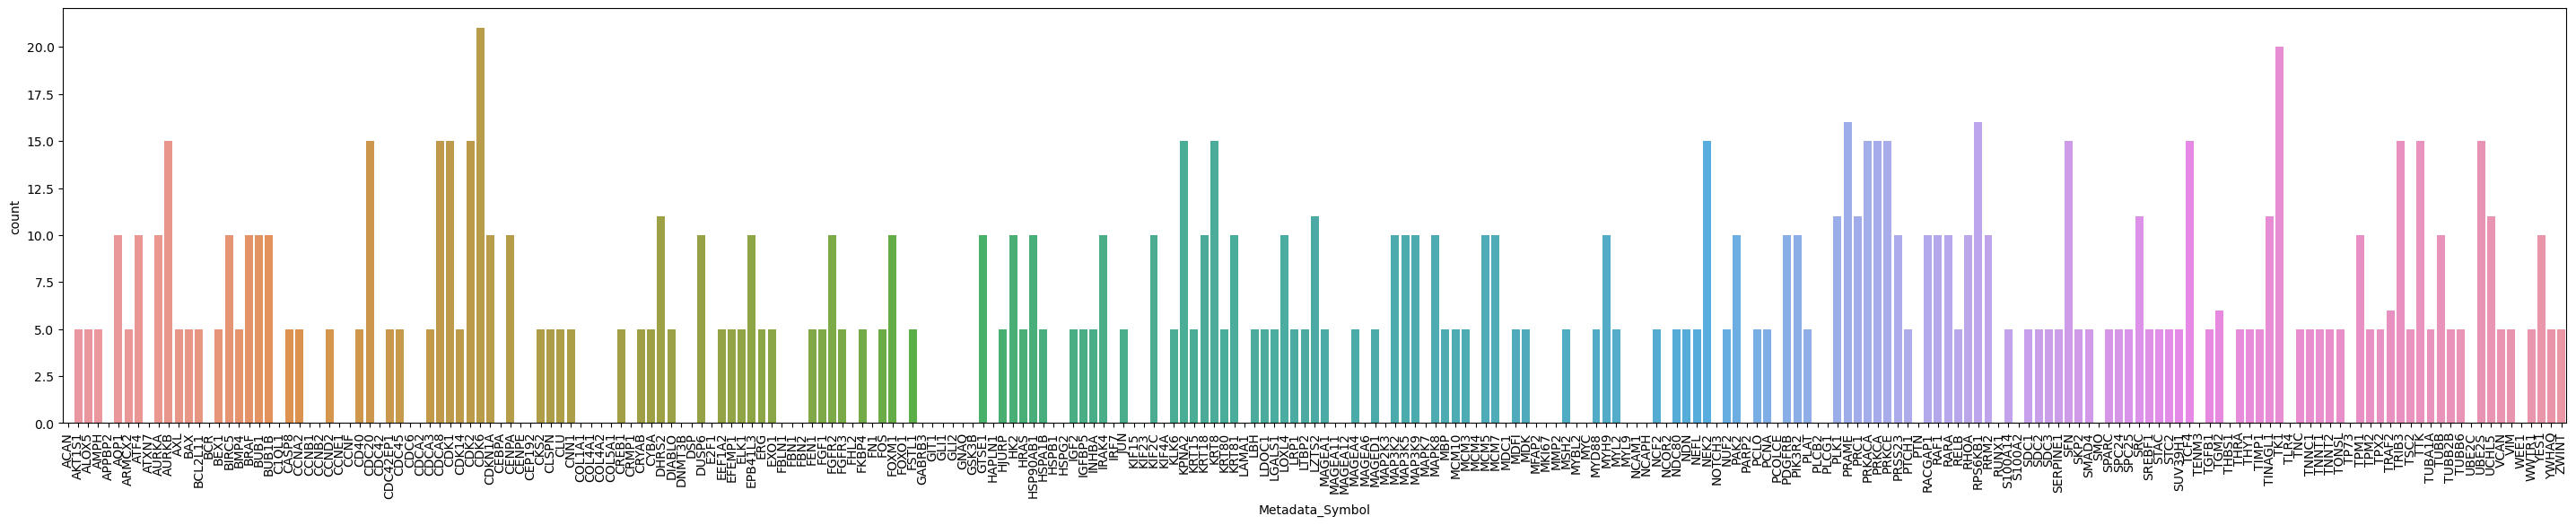

<IPython.core.display.Javascript object>

In [5]:
fig, ax = plt.subplots(figsize=[36, 6])
ax = sns.countplot(
    data=all_orf_data.loc[all_orf_data.Metadata_Symbol.isin(gene_ia_set)],
    x="Metadata_Symbol",
    order=sorted(gene_ia_set),
    # hue="Metadata_Batch",
)
plt.xticks(rotation=90)
plt.show()

As seen in the plot the JCP data set contains many of overexpression experiments that target the genes covered in the gene-gene interactome.

In total 175/249 genes are covered with an average of 7.61 +/- 3.70 wells for each as seen below.

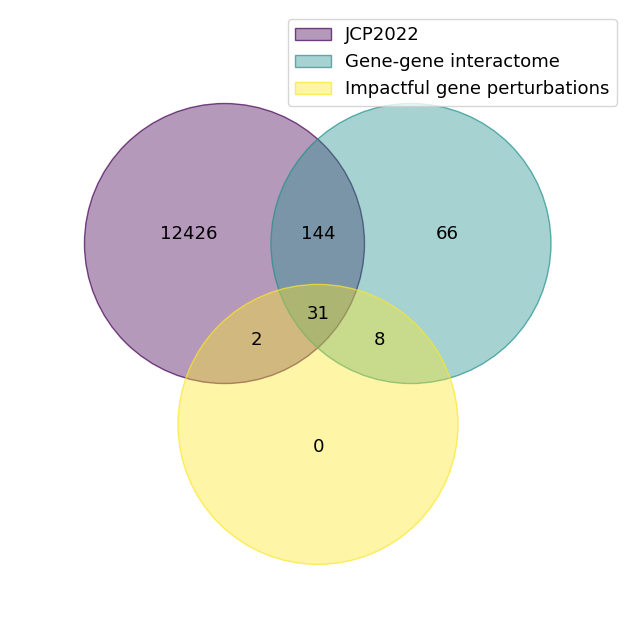

<IPython.core.display.Javascript object>

In [135]:
jcp_gene_list = set(all_orf_data.Metadata_Symbol)
ax = venn(
    {
        "JCP2022": jcp_gene_list,
        "Gene-gene interactome": gene_ia_set,
        "Impactful gene perturbations": specific_targets,
    },
)
plt.show()

In [7]:
all_orf_data.loc[all_orf_data.Metadata_Symbol.isin(gene_ia_set)].groupby(
    "Metadata_Symbol"
).count().Metadata_Source.describe()

count    175.000000
mean       7.611429
std        3.701178
min        5.000000
25%        5.000000
50%        5.000000
75%       10.000000
max       21.000000
Name: Metadata_Source, dtype: float64

<IPython.core.display.Javascript object>

It is important to mention that these were obtained from different experimental batches and potential batch effects need to be investigated.

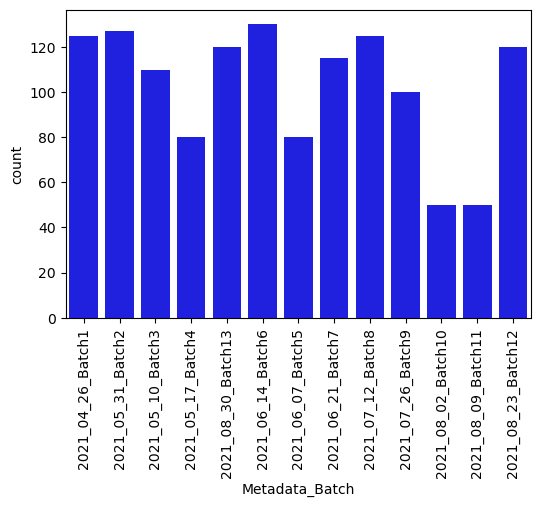

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.countplot(
    data=all_orf_data.loc[all_orf_data.Metadata_Symbol.isin(gene_ia_set)],
    x="Metadata_Batch",
    # order=sorted(gene_ia_list),
    # hue="Metadata_Batch",
    palette=["b"],
)
plt.xticks(rotation=90)
plt.show()

---

### 2.2. Selected data set

We will now further assess the dimensions of the actual image data set that is available for the overexpression condition covered in our GGI.


#### 2.2.1. Data subsetting
To this end, we first subset the metadata accordingly.

In [9]:
corf_data = all_orf_data.loc[
    all_orf_data.Metadata_Symbol.isin(gene_ia_set)
].sort_values(["Metadata_Plate", "Metadata_Well"])
corf_data.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Batch,Metadata_PlateType
103,source_4,BR00117035,E06,JCP2022_900331,ccsbBroad304_00360,ORF000135.1_TRC304.1,pLX_304,NM_134442.5,CREB1,1385,9606,cAMP responsive element binding protein 1,100.0,1023.0,trt,2021_04_26_Batch1,ORF
138,source_4,BR00117035,F18,JCP2022_902710,ccsbBroad304_02889,ORF010172.1_TRC304.1,pLX_304,NM_001348362.1,WWTR1,25937,9606,WW domain containing transcription regulator 1,100.0,1200.0,trt,2021_04_26_Batch1,ORF
180,source_4,BR00117035,H11,JCP2022_905780,ccsbBroad304_06179,ORF014130.1_TRC304.1,pLX_304,NM_182918.4,ERG,2078,9606,ETS transcription factor ERG,73.6,1428.0,trt,2021_04_26_Batch1,ORF
222,source_4,BR00117035,J05,JCP2022_900466,ccsbBroad304_00498,ORF005645.1_TRC304.1,pLX_304,NM_001114123.2,ELK1,2002,9606,ETS transcription factor ELK1,100.0,1284.0,trt,2021_04_26_Batch1,ORF
469,source_4,BR00117036,E06,JCP2022_900331,ccsbBroad304_00360,ORF000135.1_TRC304.1,pLX_304,NM_134442.5,CREB1,1385,9606,cAMP responsive element binding protein 1,100.0,1023.0,trt,2021_04_26_Batch1,ORF


<IPython.core.display.Javascript object>

In total 1,332 wells were imaged for our 175 genes. For each well we will have 9 images forming a total size of 11,988 images that will form the new data set spread across 232 plates.

---

#### 2.2.2. Scrape image-level data including cell counts

We will now scrape the corresponding image-level profile information from the AWS bucket that give us a first indication on how many nuclei per condition we are looking at although the actual number might differ as we will use our own segmentation model.

In [10]:
image_profile_formatter = (
    "https://cellpainting-gallery.s3.amazonaws.com/cpg0016-jump/"
    "{Metadata_Source}/workspace/analysis/{Metadata_Batch}/{Metadata_Plate}/analysis/{Metadata_Plate}-{Metadata_Well}-{Metadata_Site}/Image.csv"
)

<IPython.core.display.Javascript object>

In [11]:
def get_image_data(entry):
    img_dfs = []
    entry_dict = {}
    entry_dict["Metadata_Source"] = entry.Metadata_Source
    entry_dict["Metadata_Plate"] = entry.Metadata_Plate
    entry_dict["Metadata_Well"] = entry.Metadata_Well
    entry_dict["Metadata_Batch"] = entry.Metadata_Batch
    for i in range(1, 10):
        entry_dict["Metadata_Site"] = i
        s3_path = image_profile_formatter.format(**entry_dict)
        try:
            img_df = pd.read_csv(s3_path)
            img_df["Metadata_Site"] = i
            img_df["Metadata_Source"] = entry_dict["Metadata_Source"]
            img_df["Metadata_Plate"] = entry_dict["Metadata_Plate"]
            img_df["Metadata_Well"] = entry_dict["Metadata_Well"]
            img_df["Metadata_Batch"] = entry_dict["Metadata_Batch"]
        except HTTPError:
            print("URL not found:", s3_path)
            img_df = pd.DataFrame(
                entry_dict, index=["{}_{}".format(entry.Metadata_JCP2022, i)]
            )
        img_dfs.append(img_df)
    all_img_df = pd.concat(img_dfs)
    return all_img_df

<IPython.core.display.Javascript object>

In [12]:
all_img_dfs = Parallel(n_jobs=20)(
    delayed(get_image_data)(corf_data.iloc[i]) for i in tqdm(range(len(corf_data)))
)

  0%|          | 0/1332 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [13]:
all_img_df = pd.concat(all_img_dfs)
all_img_df = all_img_df.drop_duplicates(
    subset=[
        "Metadata_Source",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
    ]
)

<IPython.core.display.Javascript object>

In [14]:
all_img_df.to_hdf("metadata/covered_image_data.h5", key="data")

/tmp/ipykernel_246339/323371533.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis1] [items->None]

  all_img_df.to_hdf("metadata/covered_image_data.h5", key="data")
/tmp/ipykernel_246339/323371533.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['FileName_CellOutlines', 'FileName_IllumAGP',
       'FileName_IllumBrightfield', 'FileName_IllumBrightfield_H',
       'FileName_IllumBrightfield_L', 'FileName_IllumDNA', 'FileName_IllumER',
       'FileName_IllumMito', 'FileName_IllumRNA', 'FileName_NucleiOutlines',
       'FileName_OrigAGP', 'FileName_OrigBrightfield',
       'FileName_OrigBrightfield_H', 'FileName_OrigBrightfield_L',
       'FileName_OrigDNA', 'FileName_OrigER', 'FileName_OrigMito',
       'FileName_OrigRNA', 'MD5Diges

<IPython.core.display.Javascript object>

In [15]:
all_img_df = pd.read_hdf("metadata/covered_image_data.h5")

<IPython.core.display.Javascript object>

---

#### 2.2.3. Scrape image location information

We will also add the corresponding image file locations and the links to the illumination correction functions to the data to check if all such information are available.

In [16]:
loaddata_formatter = (
    "s3://cellpainting-gallery/cpg0016-jump/"
    "{source}/workspace/load_data_csv/"
    "{batch}/{plate}/load_data_with_illum.csv.gz"
)

<IPython.core.display.Javascript object>

In [17]:
def get_image_loc_data(entry):
    img_loc_dfs = []
    entry_dict = {}
    entry_dict["source"] = entry.Metadata_Source
    entry_dict["plate"] = entry.Metadata_Plate
    entry_dict["well"] = entry.Metadata_Well
    entry_dict["batch"] = entry.Metadata_Batch
    s3_path = loaddata_formatter.format(**entry_dict)
    try:
        img_loc_df = pd.read_csv(s3_path)
    except HTTPError:
        print("URL not found:", s3_path)
    img_loc_dfs.append(img_loc_df)
    all_img_loc_df = pd.concat(img_loc_dfs)
    return all_img_loc_df

<IPython.core.display.Javascript object>

In [18]:
all_img_loc_dfs = Parallel(n_jobs=10)(
    delayed(get_image_loc_data)(corf_data.iloc[i]) for i in tqdm(range(len(corf_data)))
)

  0%|          | 0/1332 [00:00<?, ?it/s]

URL not found: https://cellpainting-gallery.s3.amazonaws.com/cpg0016-jump/source_4/workspace/analysis/2021_08_30_Batch13/BR00123533/analysis/BR00123533-K01-2/Image.csv
URL not found: https://cellpainting-gallery.s3.amazonaws.com/cpg0016-jump/source_4/workspace/analysis/2021_08_30_Batch13/BR00123533/analysis/BR00123533-K01-3/Image.csv
URL not found: https://cellpainting-gallery.s3.amazonaws.com/cpg0016-jump/source_4/workspace/analysis/2021_08_30_Batch13/BR00124781/analysis/BR00124781-D24-5/Image.csv


<IPython.core.display.Javascript object>

In [19]:
all_img_loc_df = pd.concat(all_img_loc_dfs)
all_img_loc_df = all_img_loc_df.drop_duplicates(
    subset=[
        "Metadata_Source",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
    ]
)

<IPython.core.display.Javascript object>

In [21]:
drop_cols = []
for col in all_img_df.columns:
    if "File" in col or "Path" in col:
        drop_cols.append(col)

<IPython.core.display.Javascript object>

In [23]:
all_img_data = pd.merge(
    all_img_df.drop(columns=drop_cols),
    all_img_loc_df,
    on=[
        "Metadata_Source",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
    ],
    how="inner",
).merge(
    corf_data,
    on=["Metadata_Source", "Metadata_Batch", "Metadata_Plate", "Metadata_Well"],
)

<IPython.core.display.Javascript object>

In [24]:
all_img_data.to_hdf("metadata/covered_image_data_all.h5", key="data")

/tmp/ipykernel_246339/2236374810.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['MD5Digest_IllumAGP', 'MD5Digest_IllumBrightfield',
       'MD5Digest_IllumBrightfield_H', 'MD5Digest_IllumBrightfield_L',
       'MD5Digest_IllumDNA', 'MD5Digest_IllumER', 'MD5Digest_IllumMito',
       'MD5Digest_IllumRNA', 'MD5Digest_OrigAGP', 'MD5Digest_OrigBrightfield',
       'MD5Digest_OrigBrightfield_H', 'MD5Digest_OrigBrightfield_L',
       'MD5Digest_OrigDNA', 'MD5Digest_OrigER', 'MD5Digest_OrigMito',
       'MD5Digest_OrigRNA', 'Metadata_AbsTime', 'Metadata_ChannelName',
       'Metadata_Plate', 'Metadata_Well', 'URL_IllumAGP',
       'URL_IllumBrightfield', 'URL_IllumBrightfield_H',
       'URL_IllumBrightfield_L', 'URL_IllumDNA', 'URL_IllumER',
       'URL_IllumMito', 'URL_IllumRNA', 'URL_OrigAGP', 'URL_OrigBrightfield',
       'URL_OrigBrightfield_H', 'URL

<IPython.core.display.Javascript object>

In [25]:
all_img_data = pd.read_hdf("metadata/covered_image_data_all.h5", key="data")

<IPython.core.display.Javascript object>

In [32]:
all_img_data.loc[
    :,
    [
        "Metadata_Symbol",
        "Metadata_Batch",
        "Metadata_Plate",
        "Metadata_Well",
        "Metadata_Site",
        "PathName_OrigDNA",
        "FileName_OrigDNA",
    ],
].head()

,Metadata_Symbol,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_Site,PathName_OrigDNA,FileName_OrigDNA
0,CREB1,2021_04_26_Batch1,BR00117035,E06,1,s3://cellpainting-gallery/cpg0016-jump/source_...,r05c06f01p01-ch5sk1fk1fl1.tiff
1,CREB1,2021_04_26_Batch1,BR00117035,E06,2,s3://cellpainting-gallery/cpg0016-jump/source_...,r05c06f02p01-ch5sk1fk1fl1.tiff
2,CREB1,2021_04_26_Batch1,BR00117035,E06,3,s3://cellpainting-gallery/cpg0016-jump/source_...,r05c06f03p01-ch5sk1fk1fl1.tiff
3,CREB1,2021_04_26_Batch1,BR00117035,E06,4,s3://cellpainting-gallery/cpg0016-jump/source_...,r05c06f04p01-ch5sk1fk1fl1.tiff
4,CREB1,2021_04_26_Batch1,BR00117035,E06,5,s3://cellpainting-gallery/cpg0016-jump/source_...,r05c06f05p01-ch5sk1fk1fl1.tiff


<IPython.core.display.Javascript object>

---

### 2.3. Selected image data set

After having obtained all required information, we will now explore the data. To this end, we start of with assessing the number of covered nuclei. Note that the actual number might differ for our case as well will apply our UNet-based segmentation model. In contrast the given nuclei counts were obtained after segmenting using a classical thresholding approach.

In [136]:
all_img_data.groupby("Metadata_Symbol").mean().Count_Nuclei.describe()

count    175.000000
mean     115.312289
std       19.654756
min       28.555556
25%      107.466667
50%      120.333333
75%      127.600000
max      153.800000
Name: Count_Nuclei, dtype: float64

<IPython.core.display.Javascript object>

In total there are 1,388,812 nuclei of U2OS cells in the selected 175 U2OS conditions coming from the 11,995 FoV images of the 1,332 wells of the 232 plates imaged in 13 batches. The number of nuclei per condition ranges between 1,285 and 24,831 with an median of 5,960.

/tmp/ipykernel_246339/3067692640.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .sum()


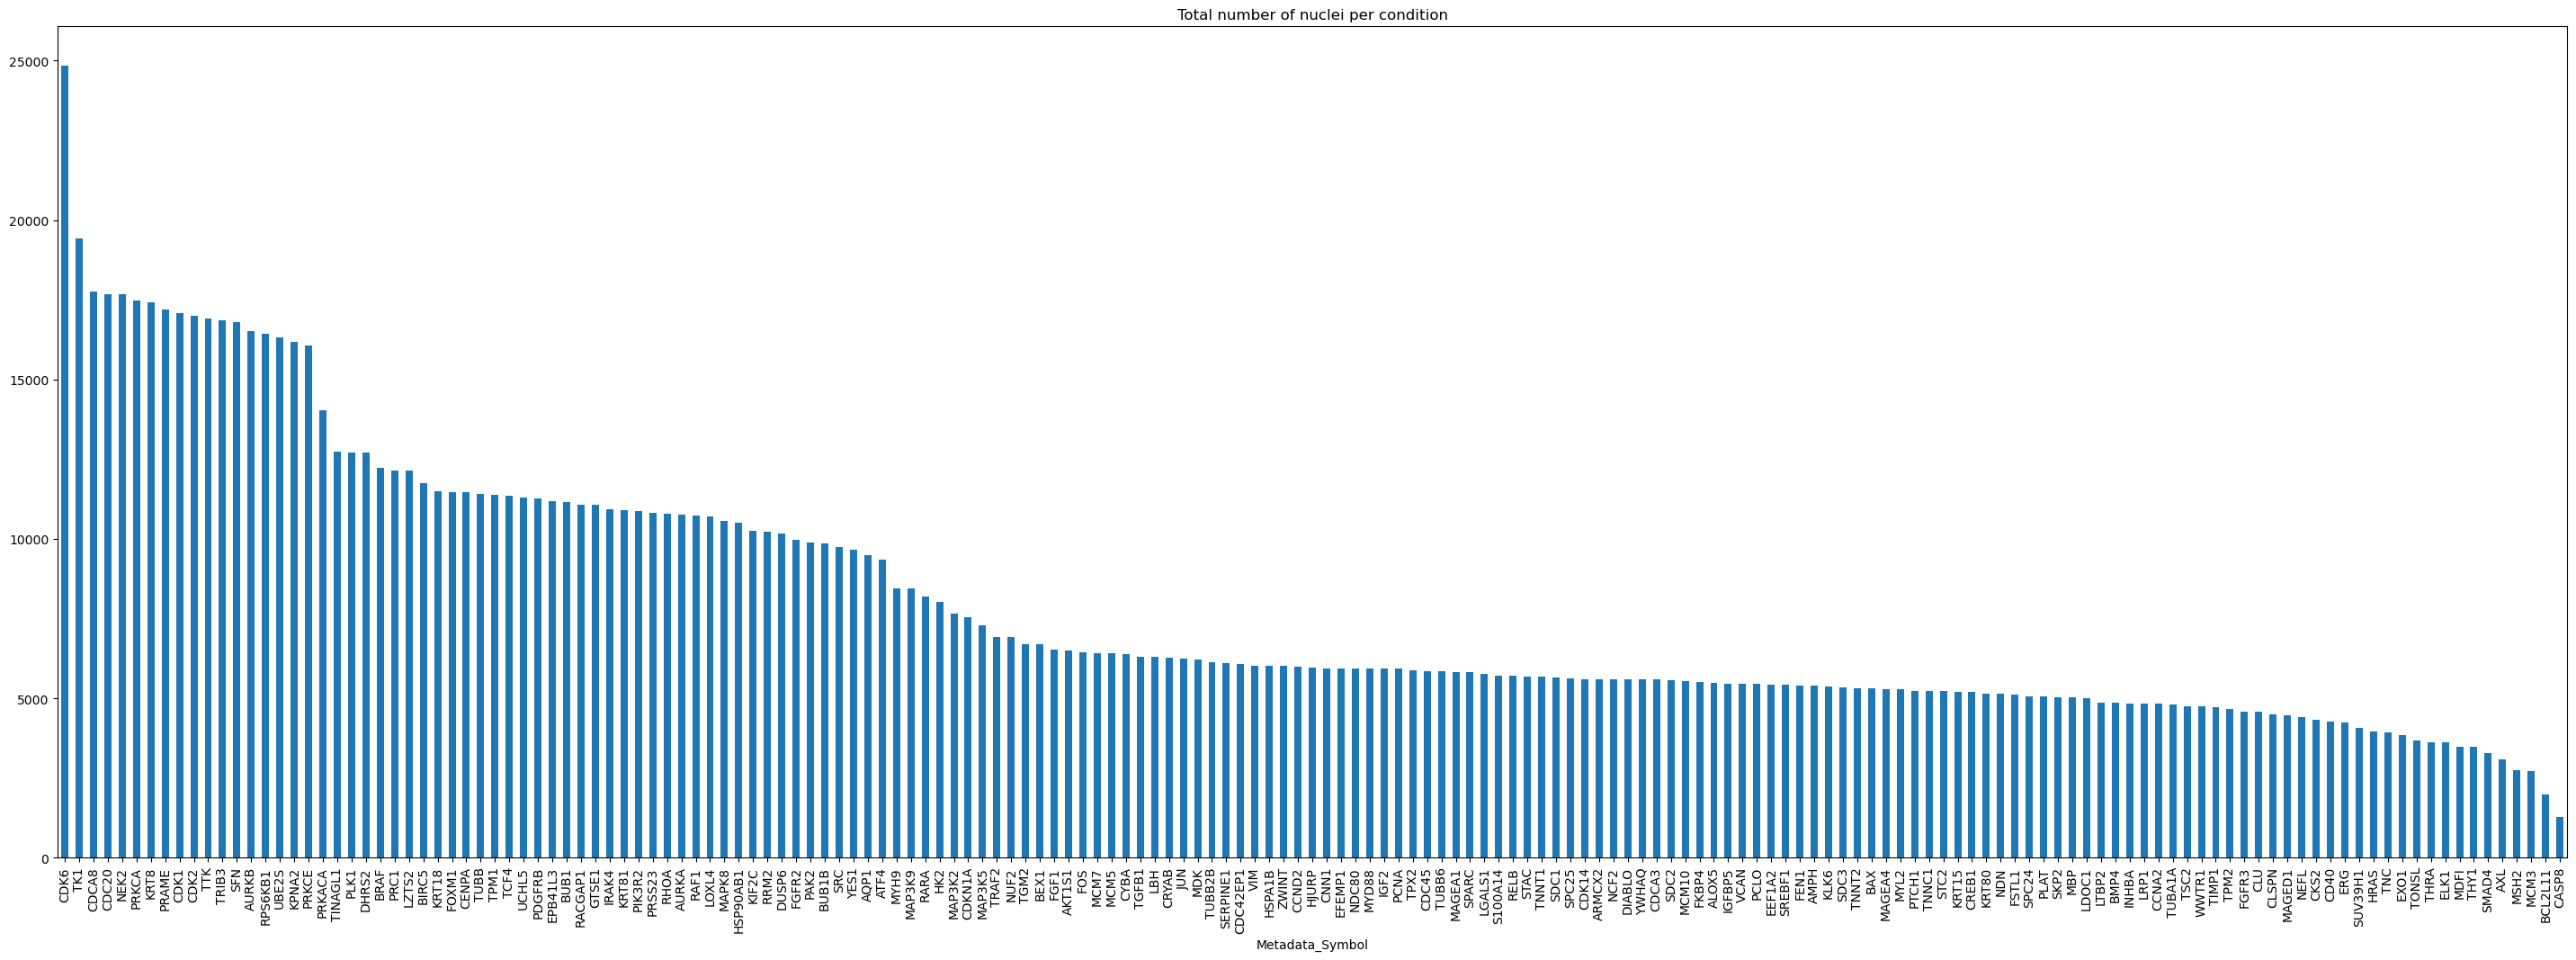

<IPython.core.display.Javascript object>

In [28]:
ax = (
    all_img_data.groupby("Metadata_Symbol")
    .sum()
    .Count_Nuclei.sort_values(ascending=False)
    .plot(kind="bar", figsize=[36, 12])
)
ax.set_title("Total number of nuclei per condition")
plt.show()

The two plots above show that the total number of nuclei corresponds to OE conditions of genes CDK6, TK1, CDCA8, CDC20 and NEK2 where as the lowest total number of nuclei is given for CASP8, BCL2L11, MCM3, MSH2 and AXL. However, those numbers are confounded by the total number of images that differs greatly between each condition.

/tmp/ipykernel_246339/2495561703.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


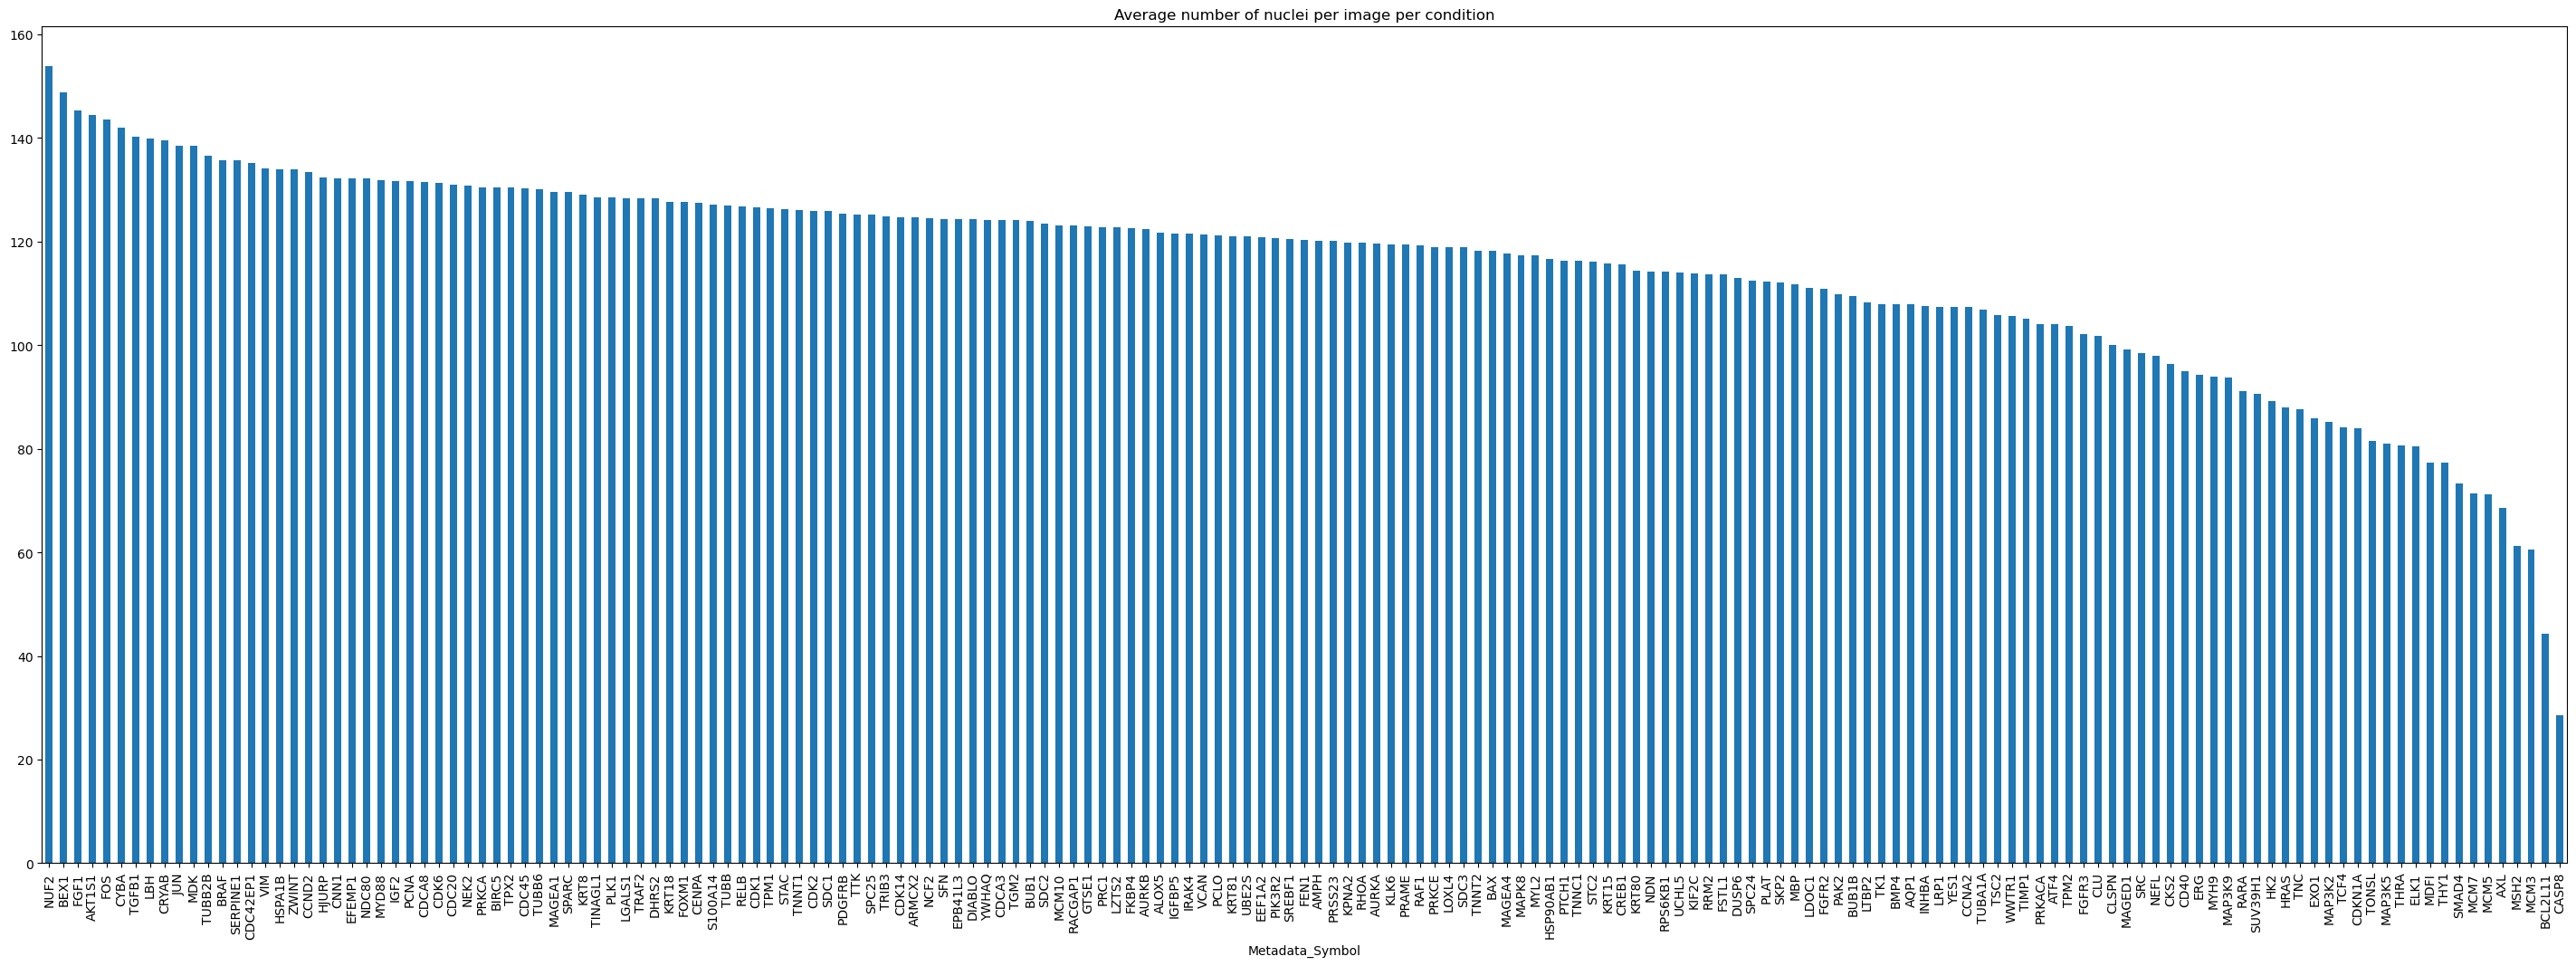

<IPython.core.display.Javascript object>

In [33]:
ax = (
    all_img_data.groupby("Metadata_Symbol")
    .mean()
    .Count_Nuclei.sort_values(ascending=False)
    .plot(kind="bar", figsize=[36, 12])
)
ax.set_title("Average number of nuclei per image per condition")
plt.show()

Thus, the above plot visualizes the average number of nuclei per condition and per image which ranges from 20 to 153 with a median of 120. In that context the conditions with the highest average number of nuclei per image are NUF2, BEX1, FGF1, AKT1S1, FOS and the ones with the lowest are CASP8, BCL2L11, MCM3, MSH2 and AXL.

Importantly the conditions with the two lowest number of nuclei per image on average are also the ones of that characteristic in the data set by Rohban et al. 2017 due to their highly toxic effect upon overexpression.

Let us know also check how correlated the cell density i.e. the average number of nuclei per images is in the JUMP and the dataset from Rohban et al 2017.

In [163]:
rohban_nuclei_counts = (
    rohban_md.groupby("Image_Metadata_GeneSymbol").mean().Image_Count_Nuclei
)

jump_nuclei_counts = all_img_data.groupby("Metadata_Symbol").mean().Count_Nuclei

nuclei_counts = pd.merge(
    rohban_nuclei_counts,
    jump_nuclei_counts,
    right_index=True,
    left_index=True,
)
nuclei_counts.columns = ["avg_nuclei_count_rohban", "avg_nuclei_count_jump"]

<IPython.core.display.Javascript object>

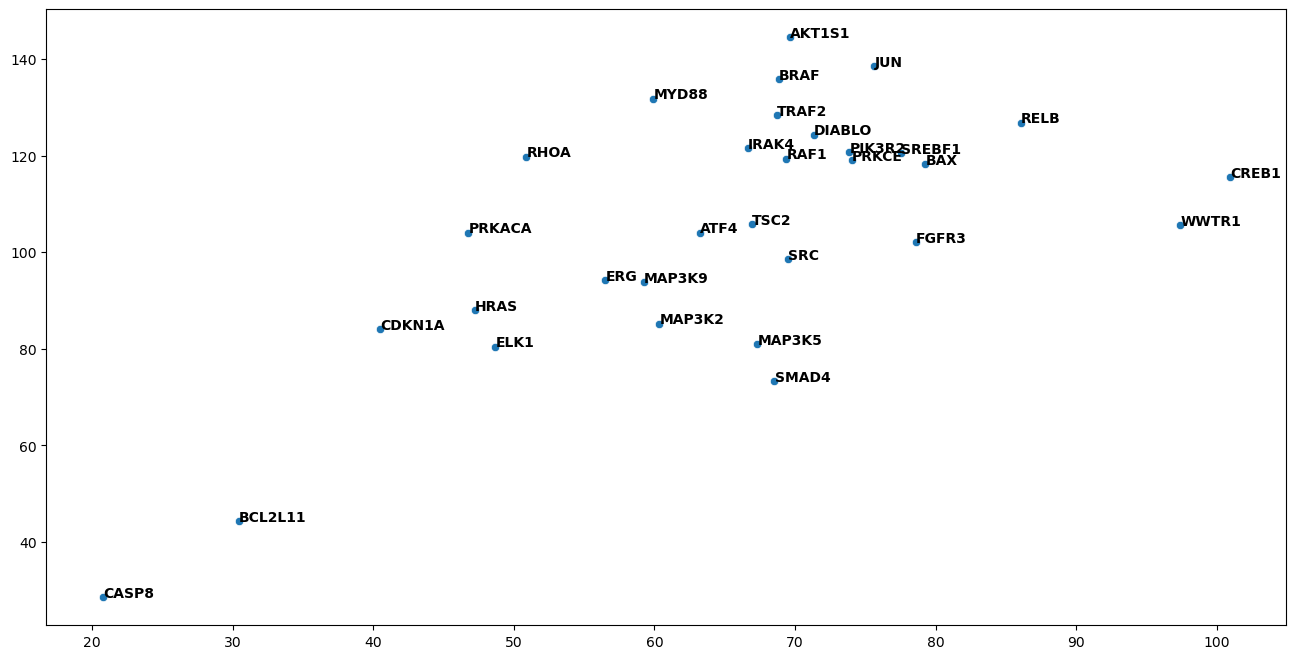

<IPython.core.display.Javascript object>

In [178]:
tmp = nuclei_counts.loc[set(nuclei_counts.index).intersection(specific_targets)]

fig, ax = plt.subplots(figsize=[16, 8])
ax = sns.scatterplot(
    data=tmp,
    x="avg_nuclei_count_rohban",
    y="avg_nuclei_count_jump",
    ax=ax,
)

# ax.set_xlabel("Rohban et al. 2017")
# ax.set_ylabel("JUMP CPG2022")
ax.set_xlabel("")
ax.set_ylabel("")

for line in range(0, tmp.shape[0]):
    ax.text(
        tmp.avg_nuclei_count_rohban[line] + 0.01,
        tmp.avg_nuclei_count_jump[line],
        tmp.index[line],
        horizontalalignment="left",
        size="medium",
        color="black",
        weight="semibold",
    )

In [172]:
pearsonr(np.array(nuclei_counts.iloc[:, 0]), np.array(nuclei_counts.iloc[:, 1]))

PearsonRResult(statistic=0.6542260759203081, pvalue=1.1241375413416589e-05)

<IPython.core.display.Javascript object>

---

### 2.4. Image analyses

We will now visualize a couple DNA images for the selected conditions. 


#### 2.4.1. Scrape sample images

To this end, we will download 9 randomly selected images for each condition.

In [44]:
output_dir = "sample_images"
n = 9

s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))

for gene in tqdm(np.unique(all_img_data.Metadata_Symbol)):
    gene_output_dir = os.path.join(output_dir, gene)
    os.makedirs(gene_output_dir, exist_ok=True)

    entry = all_img_data.loc[all_img_data.Metadata_Symbol == gene]
    sample = entry.sample(n=n, random_state=seed)

    for i in range(n):
        path_name = sample.iloc[i].PathName_OrigDNA
        file_name = sample.iloc[i].FileName_OrigDNA
        source = sample.iloc[i].Metadata_Source
        batch = sample.iloc[i].Metadata_Batch
        plate = sample.iloc[i].Metadata_Plate
        well = sample.iloc[i].Metadata_Well
        site = sample.iloc[i].Metadata_Site

        output_file_name = "_".join(
            [str(source), str(batch), str(plate), str(well), str(site), file_name]
        )

        img_url = os.path.join(path_name, file_name)
        output_file = os.path.join(gene_output_dir, output_file_name)
        s3_client.download_file(
            img_url.split("/")[2], "/".join(img_url.split("/")[3:]), output_file
        )
#         response = s3_client.get_object(
#             Bucket=img_url.split("/")[2], Key="/".join(img_url.split("/")[3:])
#         )
#         image = mpimg.imread(BytesIO(response["Body"].read()), format="tiff")
#         imwrite(os.path.join(gene_output_dir, file_name), image)

  0%|          | 0/175 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

---

##### 2.4.2. Scrape all images

While those sample images are interesting, we will now scrape all available images and thereby also create a corresponding metadata file.

In [98]:
def scrape_data_for_gene(image_data, output_dir, gene):
    gene_image_metadata = {
        "Metadata_Source": [],
        "Metadata_Batch": [],
        "Metadata_Plate": [],
        "Metadata_Well": [],
        "Metadata_Site": [],
        "Metadata_Symbol": [],
        "ImageLoc": [],
        "IllumCorFuncLoc": [],
    }
    gene_image_data = image_data.loc[image_data.Metadata_Symbol == gene]
    gene_output_dir = os.path.join(output_dir, gene)
    os.makedirs(gene_output_dir, exist_ok=True)
    # s3_client = boto3.client("s3")
    s3_client = boto3.client("s3", aws_access_key_id="", aws_secret_access_key="")
    s3_client._request_signer.sign = lambda *args, **kwargs: None

    for i in range(len(gene_image_data)):
        img_path_name = gene_image_data.iloc[i].PathName_OrigDNA
        img_file_name = gene_image_data.iloc[i].FileName_OrigDNA
        source = gene_image_data.iloc[i].Metadata_Source
        batch = gene_image_data.iloc[i].Metadata_Batch
        plate = gene_image_data.iloc[i].Metadata_Plate
        well = gene_image_data.iloc[i].Metadata_Well
        site = gene_image_data.iloc[i].Metadata_Site
        gene = gene_image_data.iloc[i].Metadata_Symbol
        illum_path_name = gene_image_data.iloc[i].PathName_IllumDNA
        illum_file_name = gene_image_data.iloc[i].FileName_IllumDNA
        illum_file_path = os.path.join(illum_path_name, illum_file_name)
        img_file_path = os.path.join(img_path_name, img_file_name)

        gene_image_metadata["Metadata_Source"].append(source)
        gene_image_metadata["Metadata_Batch"].append(batch)
        gene_image_metadata["Metadata_Plate"].append(plate)
        gene_image_metadata["Metadata_Well"].append(well)
        gene_image_metadata["Metadata_Site"].append(site)
        gene_image_metadata["Metadata_Symbol"].append(gene)

        # Define output file paths
        output_img_file_name = "_".join(
            [str(source), str(batch), str(plate), str(well), str(site), img_file_name]
        )
        gene_output_image_dir = os.path.join(gene_output_dir, "raw")
        gene_output_illum_dir = os.path.join(gene_output_dir, "illum_cor_func")
        os.makedirs(gene_output_image_dir, exist_ok=True)
        os.makedirs(gene_output_illum_dir, exist_ok=True)

        output_img_file_path = os.path.join(gene_output_image_dir, output_img_file_name)
        output_illum_file_path = os.path.join(
            gene_output_illum_dir, str(batch) + "_" + illum_file_name
        )

        # Add output locations to metadata
        gene_image_metadata["ImageLoc"].append(output_img_file_path)
        gene_image_metadata["IllumCorFuncLoc"].append(output_illum_file_path)

        # Download image & illumination correction function
        s3_client.download_file(
            img_file_path.split("/")[2],
            "/".join(img_file_path.split("/")[3:]),
            output_img_file_path,
        )
        if not os.path.exists(output_illum_file_path):
            s3_client.download_file(
                illum_file_path.split("/")[2],
                "/".join(illum_file_path.split("/")[3:]),
                output_illum_file_path,
            )
    gene_image_metadata = pd.DataFrame(gene_image_metadata)
    return gene_image_metadata

<IPython.core.display.Javascript object>

In [101]:
output_dir = "/media/paysan_d/wd_datastore/jump_data/images"

gene_image_loc_metadata = Parallel(n_jobs=20)(
    delayed(scrape_data_for_gene)(
        all_img_data,
        output_dir,
        gene,
    )
    for gene in tqdm(np.unique(all_img_data.Metadata_Symbol))
)
gene_image_loc_metadata = pd.concat(gene_image_loc_metadata)

  0%|          | 0/175 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [106]:
metadata_output_dir = os.path.join(
    "/media/paysan_d/wd_datastore/jump_data/", "metadata"
)
os.makedirs(metadata_output_dir, exist_ok=True)

gene_image_loc_metadata.to_csv(
    os.path.join(metadata_output_dir, "image_loc_metadata.csv.gz")
)
all_img_data.to_csv(os.path.join(metadata_output_dir, "image_metadata.csv.gz"))

<IPython.core.display.Javascript object>

---

##### 2.4.3 Illumination correction

After having scraped all images from the AWS bucket including the respective illumination correction functions, we now obtain illumination corrected images by simply applying those functions, i.e. deviding the raw image by the illumination correction function.

In [118]:
def correct_illumination_for_gene(img_loc_data, output_dir, gene):
    illum_img_paths = []
    gene_output_dir = os.path.join(output_dir, gene, "illum_corrected")
    os.makedirs(gene_output_dir, exist_ok=True)
    gene_img_loc_data = img_loc_data.loc[img_loc_data.Metadata_Symbol == gene].copy()

    for i in range(len(gene_img_loc_data)):
        img_path = gene_img_loc_data.iloc[i].ImageLoc
        illum_path = gene_img_loc_data.iloc[i].IllumCorFuncLoc

        img = imread(img_path)
        illum_cor_func = np.load(illum_path)
        illum_cor_img = np.uint16(img / illum_cor_func)

        illum_cor_img_file_name = os.path.split(img_path)[1]
        illum_cor_img_file_name = illum_cor_img_file_name.split(".")
        illum_cor_img_file_name = (
            illum_cor_img_file_name[0] + "_illumcor." + illum_cor_img_file_name[1]
        )

        illum_cor_img_file_path = os.path.join(gene_output_dir, illum_cor_img_file_name)
        imwrite(illum_cor_img_file_path, illum_cor_img)
        illum_img_paths.append(illum_cor_img_file_path)
    gene_img_loc_data.loc[:, "IllumImageLoc"] = np.array(illum_img_paths)
    return gene_img_loc_data

<IPython.core.display.Javascript object>

In [119]:
output_dir = "/media/paysan_d/wd_datastore/jump_data/images"
gene_illum_image_loc_metadata = Parallel(n_jobs=20)(
    delayed(correct_illumination_for_gene)(
        gene_image_loc_metadata,
        output_dir,
        gene,
    )
    for gene in tqdm(np.unique(gene_image_loc_metadata.Metadata_Symbol))
)
gene_illum_image_loc_metadata = pd.concat(gene_illum_image_loc_metadata)

  0%|          | 0/175 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [121]:
gene_illum_image_loc_metadata.to_csv(
    os.path.join(metadata_output_dir, "image_loc_metadata.csv.gz")
)

<IPython.core.display.Javascript object>

In [186]:
rohban_loc_md

,ImageNumber,Image_Metadata_Plate,Image_Metadata_Well,Image_FileName_OrigHoechst,Image_FileName_IllumHoechst,Image_FileName_NucleiOutlines,Image_Count_Nuclei,Image_Metadata_GeneID,Image_Metadata_GeneSymbol,Image_Metadata_IsLandmark,...,Image_Metadata_IntendedOrfMismatch,Image_Metadata_OpenOrClosed,Image_Metadata_RNAiVirusPlateName,Image_Metadata_Site,Image_Metadata_TimePoint_Hours,Image_Metadata_Type,Image_Metadata_Virus_Vol_ul,Image_Metadata_ASSAY_WELL_ROLE,Image_Metadata_QCFlag_isBlurry,Image_Metadata_QCFlag_isSaturated
0,2347,41744,k21,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,taoe005-u2os-72h-cp-a-au00044859_k21_s7_w10efe...,k21_s7_NucleiOutlines.png,60,1977.0,EIF4E,0.0,...,NaN,open,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
1,1840,41744,i13,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,taoe005-u2os-72h-cp-a-au00044859_i13_s4_w13be2...,i13_s4_NucleiOutlines.png,69,22943.0,DKK1,0.0,...,NaN,open,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0
2,2088,41744,j16,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,taoe005-u2os-72h-cp-a-au00044859_j16_s9_w1b03e...,j16_s9_NucleiOutlines.png,48,22926.0,ATF6,1.0,...,NaN,open,ORA11.12.13.18A,9,72H,ORF OE,1,Treated,0,0
3,2651,41744,m07,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,taoe005-u2os-72h-cp-a-au00044859_m07_s5_w1226d...,m07_s5_NucleiOutlines.png,57,5045.0,FURIN,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
4,1760,41744,i04,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,taoe005-u2os-72h-cp-a-au00044859_i04_s5_w1f731...,i04_s5_NucleiOutlines.png,51,5599.0,MAPK8,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20731,18835,41757,h05,taoe005-u2os-72h-cp-a-au00044858_h05_s7_w151b5...,taoe005-u2os-72h-cp-a-au00044858_h05_s7_w151b5...,h05_s7_NucleiOutlines.png,49,5598.0,MAPK7,0.0,...,mismatch,closed,ORA11.12.13.18A,7,72H,ORF OE,1,Treated,0,0
20732,18489,41757,f15,taoe005-u2os-72h-cp-a-au00044858_f15_s3_w173f8...,taoe005-u2os-72h-cp-a-au00044858_f15_s3_w173f8...,f15_s3_NucleiOutlines.png,105,1843.0,DUSP1,0.0,...,mismatch,closed,ORA11.12.13.18A,3,72H,ORF OE,1,Treated,0,0
20733,18275,41757,e15,taoe005-u2os-72h-cp-a-au00044858_e15_s5_w19f1a...,taoe005-u2os-72h-cp-a-au00044858_e15_s5_w19f1a...,e15_s5_NucleiOutlines.png,55,5567.0,PRKACB,0.0,...,NaN,open,ORA11.12.13.18A,5,72H,ORF OE,1,Treated,0,0
20734,18490,41757,f15,taoe005-u2os-72h-cp-a-au00044858_f15_s4_w19b6a...,taoe005-u2os-72h-cp-a-au00044858_f15_s4_w19b6a...,f15_s4_NucleiOutlines.png,61,1843.0,DUSP1,0.0,...,mismatch,closed,ORA11.12.13.18A,4,72H,ORF OE,1,Treated,0,0


<IPython.core.display.Javascript object>

---

#### 2.4.4 Visualization of the images

After having finished the initial preprocessing we will now visualize a montage of 9 randomly picked images for each gene.

In [202]:
def quant_normalize(img, qs):
    lower = np.quantile(img, qs[0])
    higher = np.quantile(img, qs[1])
    scaled = (img - lower) / (higher - lower)
    scaled = scaled * 255.0
    scaled = np.clip(scaled, 0, 255).astype(np.uint8)
    return scaled

<IPython.core.display.Javascript object>

In [203]:
selected_perts = ["JUN", "MAP3K9", "BRAF", "CASP8"]
rohban_loc_md = pd.read_csv(
    "/home/paysan_d/PycharmProjects/image2reg/data/experiments/image_preprocessing/full_pipeline/filtered_image_metadata.csv",
    index_col=0,
)
rohban_img_dir = "/home/paysan_d/PycharmProjects/image2reg/data/experiments/image_preprocessing/full_pipeline/filtered"
jump_loc_md = gene_illum_image_loc_metadata.copy()

output_dir = "viz_data"


for gene in selected_perts:
    entry_jump = jump_loc_md.loc[jump_loc_md.Metadata_Symbol == gene]
    entry_rohban = rohban_loc_md.loc[rohban_loc_md.Image_Metadata_GeneSymbol == gene]
    gene_output_dir = os.path.join(output_dir, gene)
    jump_gene_output_dir = os.path.join(gene_output_dir, "jump")
    rohban_gene_output_dir = os.path.join(gene_output_dir, "rohban")
    os.makedirs(jump_gene_output_dir, exist_ok=True)
    os.makedirs(rohban_gene_output_dir, exist_ok=True)

    entry_jump = entry_jump.sample(9, random_state=seed)
    entry_rohban = entry_rohban.sample(9, random_state=seed)

    for i in range(9):
        jump_sample = entry_jump.iloc[i]
        rohban_sample = entry_rohban.iloc[i]

        jump_fpath = jump_sample.IllumImageLoc
        rohban_fpath = os.path.join(
            rohban_img_dir,
            str(rohban_sample.Image_Metadata_Plate),
            rohban_sample.Image_FileName_IllumHoechst,
        )

        jump_img = imread(jump_fpath)
        rohban_img = imread(rohban_fpath)

        jump_img = quant_normalize(jump_img, [0.01, 0.998])
        rohban_img = quant_normalize(rohban_img, [0.01, 0.998])
        imwrite(
            os.path.join(jump_gene_output_dir, "jump_{}_{}.tiff".format(gene, i)),
            jump_img,
        )
        imwrite(
            os.path.join(rohban_gene_output_dir, "rohban_{}_{}.tiff".format(gene, i)),
            rohban_img,
        )

<IPython.core.display.Javascript object>